In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib

sns.set(style="whitegrid")


In [2]:
# Load dataset (update path if needed)
df = pd.read_csv("data.csv")   
print("Shape:", df.shape)
display(df.head())
print("\nColumns:", df.columns.tolist())


Shape: (569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN



Columns: ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']


In [3]:
#  Clean: drop id and empty column if present
drop_cols = []
if 'id' in df.columns:
    drop_cols.append('id')
if 'Unnamed: 32' in df.columns:
    drop_cols.append('Unnamed: 32')

df = df.drop(columns=drop_cols)
print("Dropped:", drop_cols)
print("Shape after drop:", df.shape)


Dropped: ['id', 'Unnamed: 32']
Shape after drop: (569, 31)


In [4]:
# Encode target (B->0, M->1) and view class counts
df['diagnosis'] = df['diagnosis'].map({'B':0, 'M':1})
print(df['diagnosis'].value_counts())


diagnosis
0    357
1    212
Name: count, dtype: int64


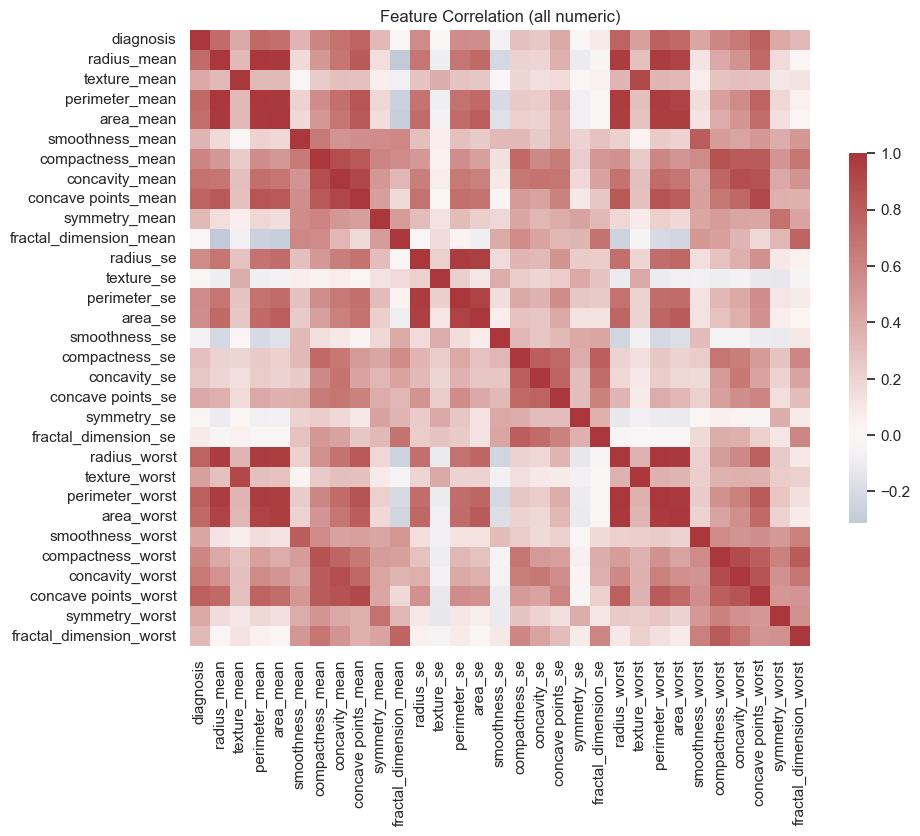

In [5]:
#  Quick EDA: correlation heatmap for numeric features 
numeric = df.select_dtypes(include=[np.number])
corr = numeric.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='vlag', center=0, cbar_kws={'shrink': .6})
plt.title("Feature Correlation (all numeric)")
plt.show()


In [6]:
# Prepare X, y and train/test split 
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

# Optional: scale numeric features 
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (455, 30) Test shape: (114, 30)


In [7]:
# Train Decision Tree 
dt = DecisionTreeClassifier(random_state=42, max_depth=6)   # max_depth keeps tree readable
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


Decision Tree Accuracy: 0.9210526315789473
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        72
           1       0.92      0.86      0.89        42

    accuracy                           0.92       114
   macro avg       0.92      0.91      0.91       114
weighted avg       0.92      0.92      0.92       114



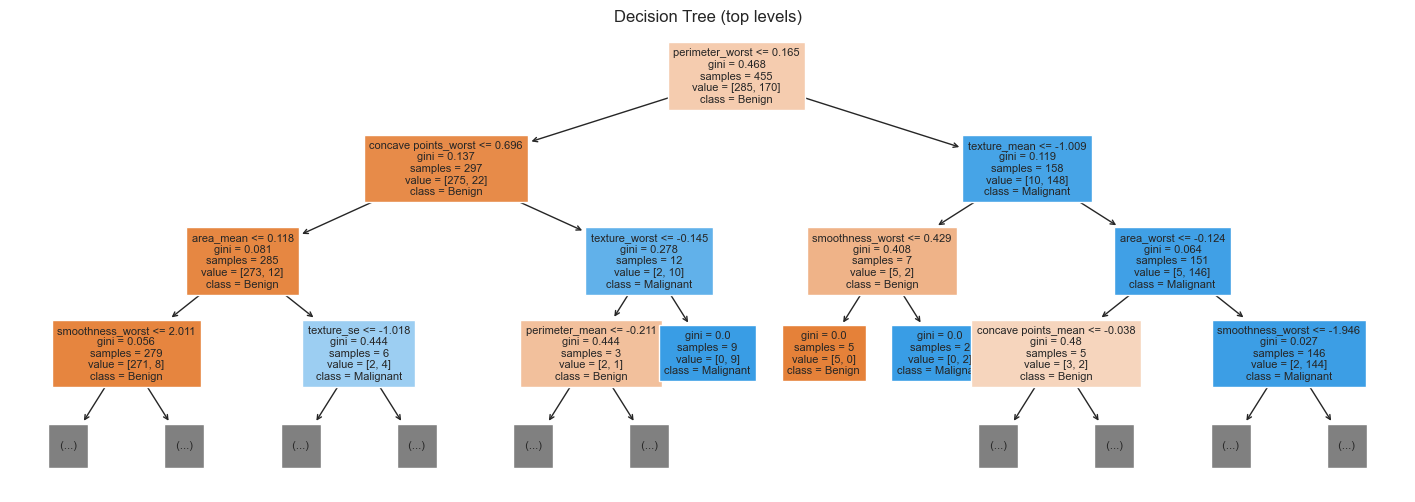

In [8]:
# Visualize top of tree 
plt.figure(figsize=(18,6))
plot_tree(dt, feature_names=X.columns, class_names=['Benign','Malignant'], filled=True, max_depth=3, fontsize=8)
plt.title("Decision Tree (top levels)")
plt.show()


ROC AUC (DT): 0.89484126984127


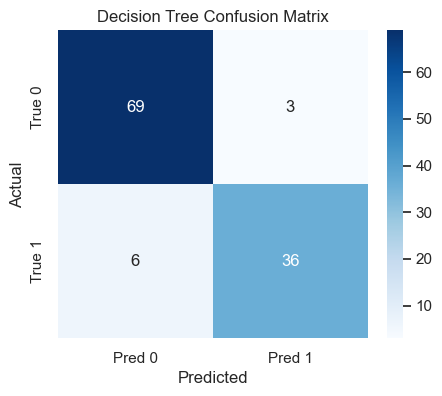

In [9]:
#  ROC AUC and Confusion Matrix
y_prob_dt = dt.predict_proba(X_test)[:,1]
print("ROC AUC (DT):", roc_auc_score(y_test, y_prob_dt))

cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
plt.title("Decision Tree Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


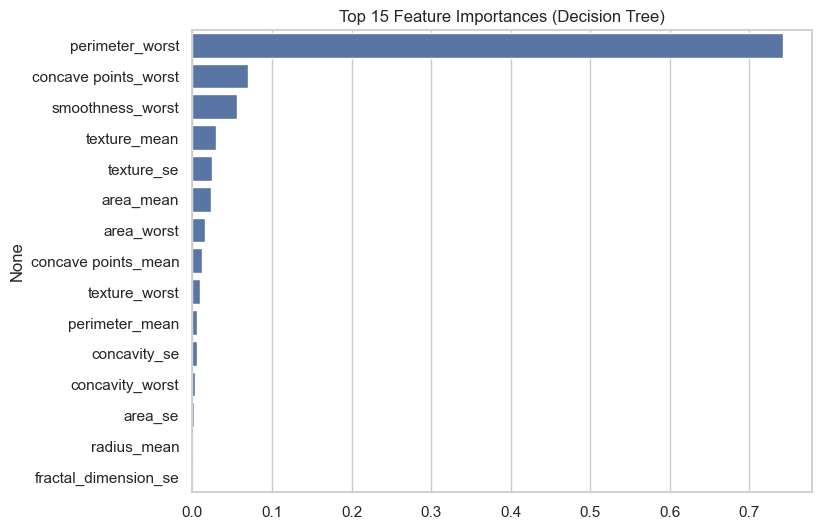

In [10]:
# Feature importance (Decision Tree)
imp = pd.Series(dt.feature_importances_, index=X.columns).sort_values(ascending=False)[:15]
plt.figure(figsize=(8,6))
sns.barplot(x=imp.values, y=imp.index)
plt.title("Top 15 Feature Importances (Decision Tree)")
plt.show()


In [11]:
# Train Random Forest 
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("ROC AUC (RF):", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))


Random Forest Accuracy: 0.9649122807017544
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114

ROC AUC (RF): 0.994212962962963


In [12]:
# Choose best model by accuracy 
acc_dt = accuracy_score(y_test, y_pred_dt)
acc_rf = accuracy_score(y_test, y_pred_rf)
best = rf if acc_rf >= acc_dt else dt

joblib.dump(best, "best_breast_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(X.columns.tolist(), "model_columns.pkl")
print("Saved best model and preprocessing artifacts. Best model is:", "RandomForest" if best is rf else "DecisionTree")


Saved best model and preprocessing artifacts. Best model is: RandomForest


In [13]:
# A) Load saved model, scaler, columns and evaluate on X_test/y_test again
import joblib, pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

best = joblib.load("best_breast_model.pkl")
scaler = joblib.load("scaler.pkl")
cols = joblib.load("model_columns.pkl")

# Ensure X_test and y_test exist in this session  If not, recreate split.
try:
    X_test  
except NameError:
    # Recreate X_test, y_test quickly 
    X = df.drop(columns=['diagnosis'])
    y = df['diagnosis']
    X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)
    from sklearn.model_selection import train_test_split
    _, X_test, _, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Predictions and basic metrics
y_pred = best.predict(X_test)
y_prob = best.predict_proba(X_test)[:,1] if hasattr(best, "predict_proba") else None

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
if y_prob is not None:
    print("\nROC AUC:", roc_auc_score(y_test, y_prob))


Accuracy: 0.9649122807017544

Classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114


Confusion matrix:
 [[72  0]
 [ 4 38]]

ROC AUC: 0.994212962962963


In [18]:
import joblib

# Save trained RandomForest model
joblib.dump(rf, "breast_cancer_best_model.pkl")

# Save preprocessing pipeline
joblib.dump(preprocessor, "breast_cancer_preprocessor.pkl")

print("✅ RandomForest model & preprocessing pipeline saved successfully!")


NameError: name 'preprocessor' is not defined

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Example preprocessing pipeline
preprocessor = ColumnTransformer([
    ('scale', StandardScaler(), numeric_features)
])

# Then fit model
rf.fit(preprocessor.fit_transform(X_train), y_train)


NameError: name 'numeric_features' is not defined

In [20]:
# Identify numeric & categorical columns from training data
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Numeric preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical preprocessing
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [22]:
#  Combine Preprocessing with Model
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])


In [23]:
#Train pipeline
rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 's...
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('model', RandomForestClassifier(random_state=42))])

In [24]:
import joblib

joblib.dump(rf_pipeline, "breast_cancer_pipeline.pkl")
print("✅ Full preprocessing + RandomForest pipeline saved successfully!")


✅ Full preprocessing + RandomForest pipeline saved successfully!


In [25]:
import joblib

# Load saved pipeline
loaded_pipeline = joblib.load("breast_cancer_pipeline.pkl")

# Test on the original test set
y_pred_loaded = loaded_pipeline.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
print("Accuracy (Loaded Model):", accuracy_score(y_test, y_pred_loaded))
print("\nClassification Report:\n", classification_report(y_test, y_pred_loaded))


Accuracy (Loaded Model): 0.9736842105263158

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



In [27]:
import pandas as pd

# Get the column names from your original training data
feature_names = X_train.columns  # This keeps the same order

# Create DataFrame for the new sample
new_sample_df = pd.DataFrame(
    [[14.1, 20.2, 93.4, 600.5, 0.092, 0.085, 0.043, 0.06, 0.18, 0.06,
      1.25, 1.5, 8.8, 100.2, 0.005, 0.01, 0.005, 0.009, 0.02, 0.003,
      17.5, 25.2, 115.5, 920.1, 0.145, 0.23, 0.088, 0.14, 0.35, 0.08]],
    columns=feature_names
)

# Make prediction
prediction = loaded_pipeline.predict(new_sample_df)
print("Prediction for new sample:", prediction)


Prediction for new sample: [1]


In [28]:
import pandas as pd
import joblib

# Load the saved pipeline ===
pipeline = joblib.load("breast_cancer_pipeline.pkl")  # Your saved full preprocessing + RandomForest

#  Define new sample(s) 
# Make sure order & columns match the training dataset exactly
feature_names = [
    'mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness',
    'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension',
    'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error',
    'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error',
    'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness',
    'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension'
]

# Example new patient data
new_sample = pd.DataFrame(
    [[14.1, 20.2, 93.4, 600.5, 0.092, 0.085, 0.043, 0.06, 0.18, 0.06,
      1.25, 1.5, 8.8, 100.2, 0.005, 0.01, 0.005, 0.009, 0.02, 0.003,
      17.5, 25.2, 115.5, 920.1, 0.145, 0.23, 0.088, 0.14, 0.35, 0.08]],
    columns=feature_names
)

#  Predict 
prediction = pipeline.predict(new_sample)
prediction_label = "Malignant" if prediction[0] == 1 else "Benign"

# . Show result 
print(f"Prediction: {prediction_label}")


ValueError: columns are missing: {'symmetry_se', 'compactness_mean', 'compactness_se', 'smoothness_mean', 'fractal_dimension_se', 'radius_mean', 'radius_worst', 'concavity_worst', 'area_mean', 'smoothness_se', 'concave points_worst', 'area_se', 'area_worst', 'symmetry_mean', 'concavity_mean', 'symmetry_worst', 'perimeter_mean', 'concave points_se', 'concave points_mean', 'fractal_dimension_mean', 'concavity_se', 'texture_se', 'smoothness_worst', 'perimeter_se', 'fractal_dimension_worst', 'texture_mean', 'radius_se', 'texture_worst', 'perimeter_worst', 'compactness_worst'}

In [29]:
feature_names = X.columns.tolist()


In [30]:
#Creating new sample for prediction
new_sample = pd.DataFrame(
    [[14.1, 20.2, 93.4, 600.5, 0.092, 0.085, 0.043, 0.06, 0.18, 0.06,
      1.25, 1.5, 8.8, 100.2, 0.005, 0.01, 0.005, 0.009, 0.02, 0.003,
      17.5, 25.2, 115.5, 920.1, 0.145, 0.23, 0.088, 0.14, 0.35, 0.08]],
    columns=feature_names
)


In [31]:
prediction = pipeline.predict(new_sample)
prediction_label = "Malignant" if prediction[0] == 1 else "Benign"
print("Prediction:", prediction_label)


Prediction: Malignant
